# Step 5 - First steps towards fitting models to data

In the first three steps we've built up a framework that allows us to load stellar models, filter curves and combine them at any observed redshift, briefly we'll re-input that code, each of the three functions below are condensed versions of the ground we covered in the first three examples respectively.

In [59]:
import numpy as np

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)


def get_model_grid():
    """ Loads up the BPASS grid of stellar models and resamples it onto a coarser wavelength grid. See Step 1. """
    
    raw_wavelengths = np.loadtxt("data/spectra-bin-imf135_300.z020.dat", usecols=0)
    raw_grid = np.loadtxt("data/spectra-bin-imf135_300.z020.dat")[:,1:]
    
    grid = np.zeros((wavelengths.shape[0], raw_grid.shape[1]))

    for i in range(grid.shape[1]):
        grid[:,i] = np.interp(wavelengths, raw_wavelengths, raw_grid[:,i])
    
    grid *= (3.827*10**33)/(10**6)

    return grid

    
def blueshift_filters(redshift):
    """ A function that resamples filters onto the same wavelength
    basis as the model spectrum at the specified redshift. See Step 2. """
    
    resampled_filter_curves = []

    for filt in filter_curves:
        resampled_filt = np.interp(wavelengths, filt[:, 0]/(1 + redshift), filt[:, 1], left=0, right=0)
        resampled_filter_curves.append(resampled_filt)
        
    return resampled_filter_curves


def get_model_photometry(redshift, age_index):
    """ For a row in the model grid return model photometry at the specified redshifts. See Step 3. """

    ssp_model = np.copy(grid[:, age_index])
    
    luminosity_distance = (3.086*10**24)*cosmo.luminosity_distance(redshift).value

    ssp_model /= 4*np.pi*(1 + redshift)*luminosity_distance**2

    filter_curves_z = blueshift_filters(redshift)

    photometry = np.zeros(len(filter_curves))

    for i in range(photometry.shape[0]):
        flux_contributions = filter_curves_z[i]*ssp_model
        photometry[i] = np.trapz(flux_contributions, x=wavelengths*(1 + redshift))
        photometry[i] /= np.trapz(filter_curves_z[i], x=wavelengths*(1 + redshift))
        
    return photometry


Let's also re-input the function we wrote in Step 4 to load up observational data.

In [60]:
def load_data(row_no):
    """ Load UltraVISTA photometry from catalogue. See Step 4. """

    # load up the relevant columns from the catalogue.
    catalogue = np.loadtxt("data/UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))
    
    # Extract the object we're interested in from the catalogue.
    fluxes = catalogue[row_no, 1:13]
    fluxerrs = catalogue[row_no, 13:25]

    # Convert to microjanskys
    fluxes = fluxes*10**29
    fluxerrs = fluxerrs*10**29    

    return fluxes, fluxerrs

There's also some other basic setting up we should do to define the variables we're going to need.

In [61]:
# Define our basic quantities.
wavelengths = np.arange(1000., 60000., 10.)
ages = np.arange(2, 53)
ages = 10**(6+0.1*(ages-2))

grid = get_model_grid()

# Load the curves up.
filter_names = ["data/filters/CFHT_u.txt",
                "data/filters/CFHT_g.txt",
                "data/filters/CFHT_r.txt",
                "data/filters/CFHT_i+i2.txt",
                "data/filters/CFHT_z.txt",
                "data/filters/subaru_z",
                "data/filters/VISTA_Y.txt",
                "data/filters/VISTA_J.txt",
                "data/filters/VISTA_H.txt",
                "data/filters/VISTA_Ks.txt",
                "data/filters/IRAC1",
                "data/filters/IRAC2"]

filter_curves = []

for name in filter_names:
    filter_curves.append(np.loadtxt(name))
    
eff_wavs = np.zeros(len(filter_curves))

# Calculate the effective wavelengths of the filter curves
for i in range(len(filter_curves)):
    filt = filter_curves[i]

    wav_weights = filt[:,1]*filt[:,0]
    
    eff_wavs[i] = np.trapz(wav_weights, x=filt[:,0])

    eff_wavs[i] /= np.trapz(filt[:, 1], x=filt[:,0])

# Now that that's over with...

Having got all that out of the way let's think about how to go about fitting to data. The simplest way to do this is grid-based fitting. Basically we're going to pick a bunch of redshift, age and mass values making up a 3D grid, then calculate chi-squared values at each point and see which one is smallest. Let's start with a single point to develop the idea.

We can only use discrete fixed age values corresponding to the ages we have spectra for in the BPASS model grid, so let's just leave things in terms of the column index in the grid instead of actual ages in years for now.

In [62]:
mass = 10**10  # Solar masses
redshift = 1.
age_index = 25

# Our photometry is in erg/s/cm^2/A per Solar mass of stars
model_photometry = get_model_photometry(redshift, age_index)

# Convert to erg/s/cm^2/A by multiplying by the total mass we want.
model_photometry *= mass

# Our observational data is in microJanskys.
fluxes, fluxerrs = load_data(1)

Would you look at that, we have a not-at-all-contrived unit mismatch between our model and our photometric data. Converting between flux per unit angstron and flux per unit frequency is the bane of my (and I presume other people in the field's too) existance, I always have to work it out from scratch every time.

Let's turn our microJansky observational data into erg/s/cm^2/A and quickly plot the result.

In [63]:
# Convert from muJy to erg/s/cm^2/Hz.
fluxes = fluxes*10**-29
fluxerrs = fluxerrs*10**-29

fluxes = fluxes*2.9979*10**18/eff_wavs**2
fluxerrs = fluxerrs*2.9979*10**18/eff_wavs**2

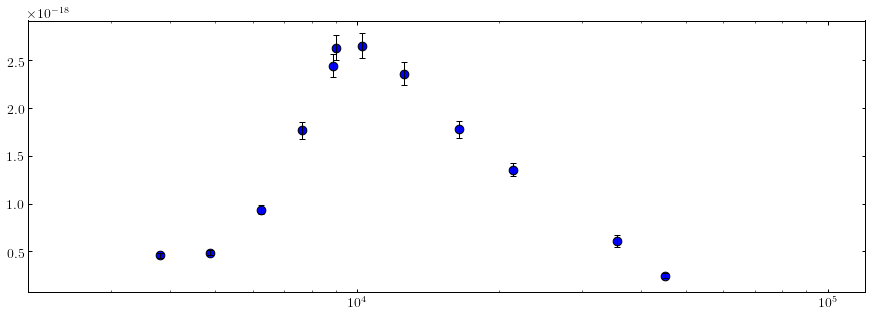

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.errorbar(eff_wavs, fluxes, yerr=fluxerrs, lw=1.0, linestyle=" ", capsize=3, capthick=1, color="black")
plt.scatter(eff_wavs, fluxes, s=75, linewidth=1, facecolor="blue", edgecolor="black")
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()

Ok, now we have our units the same let's calculate a chi-squared value.

In [65]:
diffs = fluxes - model_photometry

chisq = np.sum(diffs**2/fluxerrs**2)

print "Chi-squared value:", chisq

Chi-squared value: 3505.00926591


Not great, let's see if we can iterate towards a better solution. First plot this model over the data.

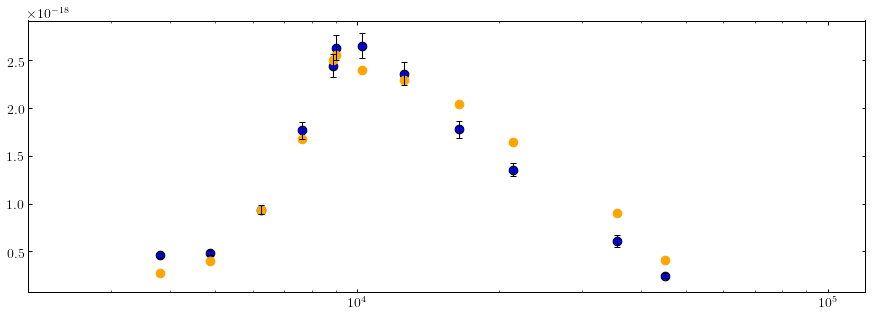

In [70]:
plt.figure(figsize=(15, 5))
plt.errorbar(eff_wavs, fluxes, yerr=fluxerrs, lw=1.0, linestyle=" ", capsize=3, capthick=1, color="black")
plt.scatter(eff_wavs, fluxes, s=75, linewidth=1, facecolor="blue", edgecolor="black")
plt.scatter(eff_wavs, model_photometry, s=75, facecolor="orange")
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()

Whilst it may not be obvious if you're new to this, once you've spent a long time looking at these kind of plots you'll be able to tell that it looks like the redshift is pretty good, but we've underestimated the age and the mass. Let's try again by stepping up by 0.5 dex in mass and 5 in our age index.

Chi-squared value: 164.328666499


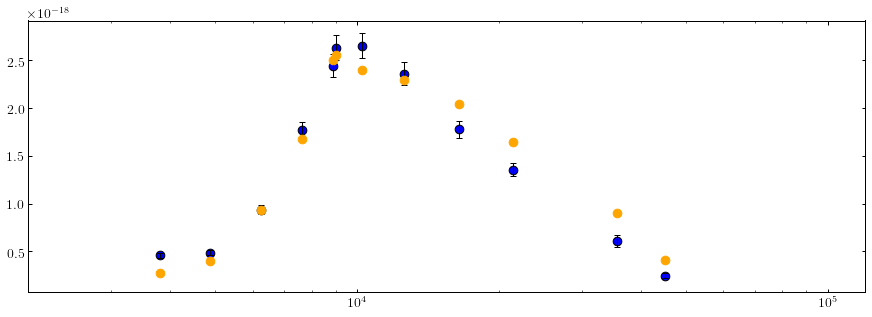

In [71]:
mass = 10**10.5  # Solar masses
redshift = 1.
age_index = 30

# Our photometry is in erg/s/cm^2/A per Solar mass of stars
model_photometry = get_model_photometry(redshift, age_index)

# Convert to erg/s/cm^2/A by multiplying by the total mass we want.
model_photometry *= mass

diffs = fluxes - model_photometry

chisq = np.sum(diffs**2/fluxerrs**2)

print "Chi-squared value:", chisq

plt.figure(figsize=(15, 5))
plt.errorbar(eff_wavs, fluxes, yerr=fluxerrs, lw=1.0, linestyle=" ", capsize=3, capthick=1, color="black")
plt.scatter(eff_wavs, fluxes, s=75, linewidth=1, facecolor="blue", edgecolor="black")
plt.scatter(eff_wavs, model_photometry, s=75, facecolor="orange", zorder=10)
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()

We're already doing a lot better, but it's still going to take forever to get anywhere this way. Let's go to the next step and iterate over a grid of points in order to make things faster.